In [ ]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from numpy import isnan
from pandas import read_csv

In [ ]:
!pip install datasets

In [1]:
from huggingface_hub import login

login()


In [ ]:
from datasets import load_dataset

ds = load_dataset("PeterBrendan/AdImageNet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Voir un aperçu général du dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'dimensions'],
        num_rows: 9003
    })
})


In [ ]:
print(ds["train"].features)


{'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None), 'dimensions': Value(dtype='string', id=None)}


In [ ]:
print(ds["train"][0])  # Premier exemple du dataset


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x600 at 0x7BFFA8F0D790>, 'text': 'Supplements You Trust\nOrganix\nResults You Love\nOrgani\nMAGNESIUM\nIak\nDietary Supplement\n001\n14,000+\n5 STAR\nREVIEWS\nOrganixor\nMagnesium 7\nComplete\nFull-Spectrum\nDaily Magnesium\nSupplement\nBUY NOW', 'dimensions': '(160, 600)'}


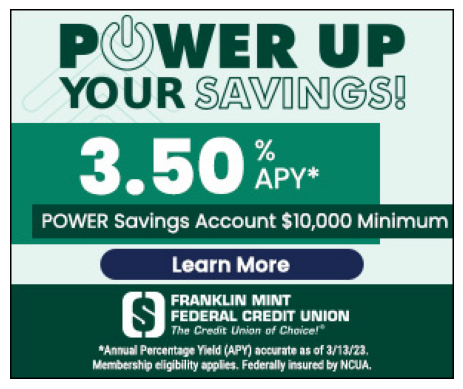

In [ ]:

import matplotlib.pyplot as plt

# Afficher une image du dataset
image = ds["train"][15]["image"]  # Récupérer la première image
plt.imshow(image, cmap="gray")  # Affichage (ajouter cmap="gray" si c'est en noir et blanc)
plt.axis("off")  # Enlever les axes
plt.show()


In [ ]:
print(ds["train"].column_names)


['image', 'text', 'dimensions']


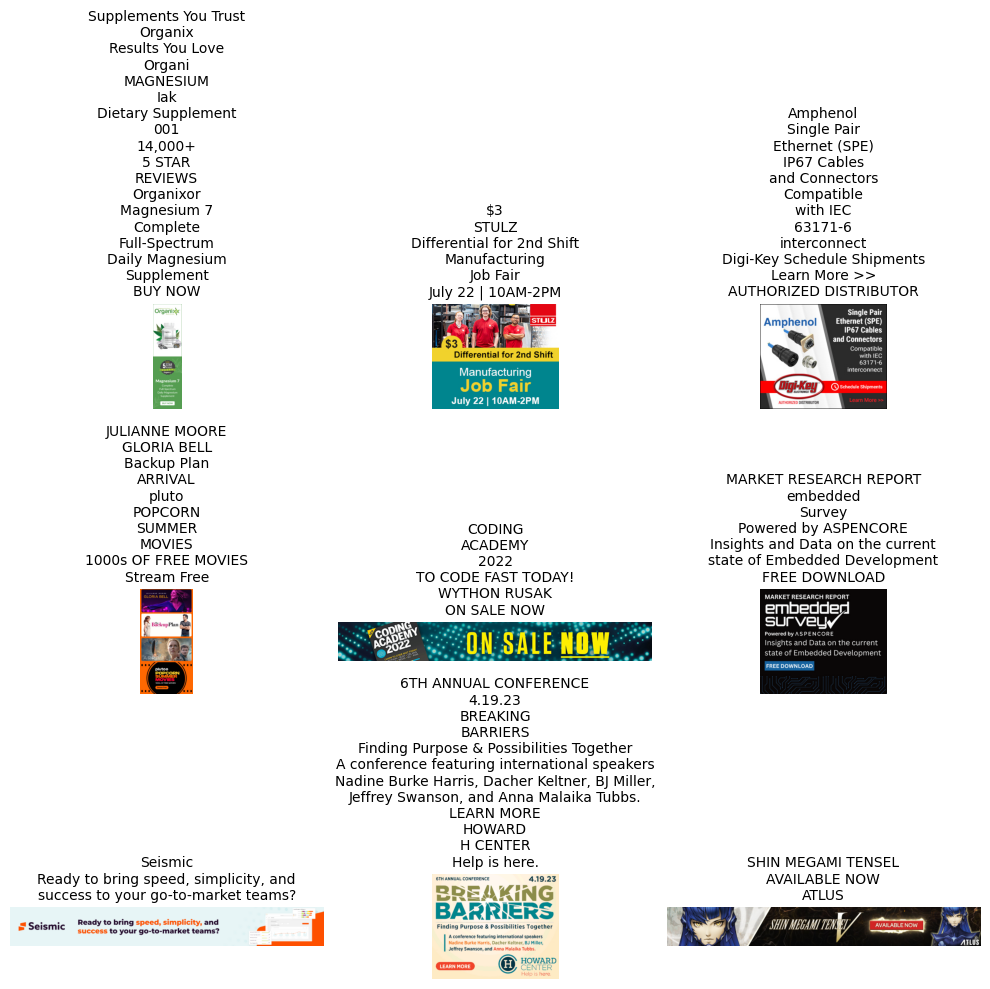

In [ ]:
import matplotlib.pyplot as plt

# Sélectionner un nombre d'images à afficher
num_images = 9
images = [ds["train"][i]["image"] for i in range(num_images)]
texts = [ds["train"][i]["text"] for i in range(num_images)]

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Afficher chaque image avec son texte associé
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # Afficher l'image
    ax.set_title(texts[i], fontsize=10)  # Ajouter le texte
    ax.axis("off")  # Cacher les axes

# Afficher l'ensemble des images
plt.tight_layout()
plt.show()


,Image,Description
0,,"Supplements You Trust Organix Results You Love Organi MAGNESIUM Iak Dietary Supplement 001 14,000+ 5 STAR REVIEWS Organixor Magnesium 7 Complete Full-Spectrum Daily Magnesium Supplement BUY NOW"
1,,$3 STULZ Differential for 2nd Shift Manufacturing Job Fair July 22 | 10AM-2PM
2,,Amphenol Single Pair Ethernet (SPE) IP67 Cables and Connectors Compatible with IEC 63171-6 interconnect Digi-Key Schedule Shipments Learn More >> AUTHORIZED DISTRIBUTOR
3,,JULIANNE MOORE GLORIA BELL Backup Plan ARRIVAL pluto POPCORN SUMMER MOVIES 1000s OF FREE MOVIES Stream Free
4,,CODING ACADEMY 2022 TO CODE FAST TODAY! WYTHON RUSAK ON SALE NOW
5,,MARKET RESEARCH REPORT embedded Survey Powered by ASPENCORE Insights and Data on the current state of Embedded Development FREE DOWNLOAD
6,,"Seismic Ready to bring speed, simplicity, and success to your go-to-market teams?"
7,,"6TH ANNUAL CONFERENCE 4.19.23 BREAKING BARRIERS Finding Purpose & Possibilities Together A conference featuring international speakers Nadine Burke Harris, Dacher Keltner, BJ Miller, Jeffrey Swanson, and Anna Malaika Tubbs. LEARN MORE HOWARD H CENTER Help is here."
8,,SHIN MEGAMI TENSEL AVAILABLE NOW ATLUS

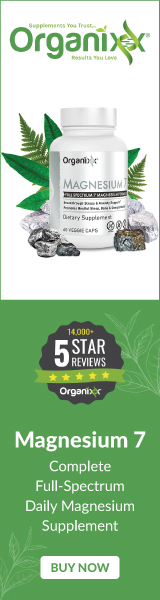
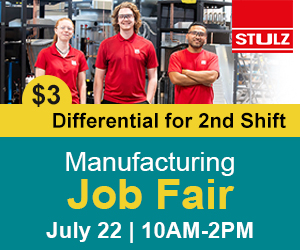
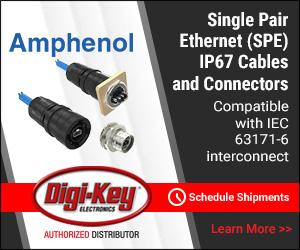
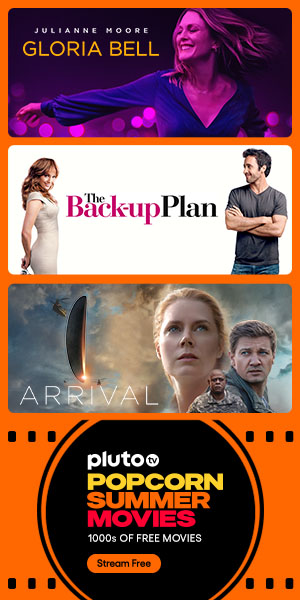
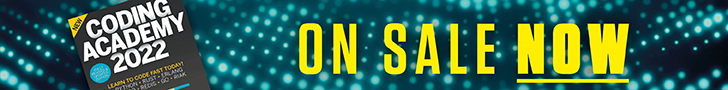
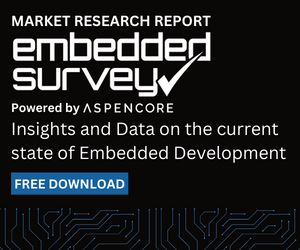
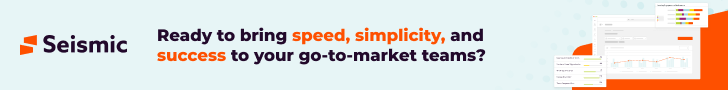
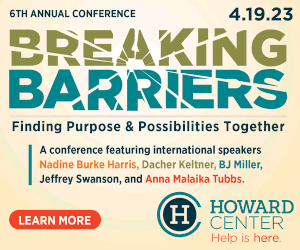
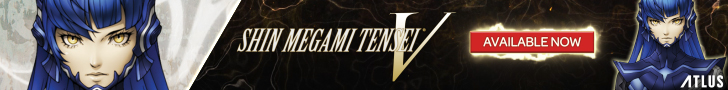

In [ ]:
import pandas as pd
import base64
from IPython.core.display import display, HTML
from io import BytesIO

# Fonction pour convertir une image en base64 (pour affichage dans HTML)
def image_to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f'<img src="data:image/png;base64,{img_str}" width="100"/>'

# Nombre d'images à afficher
num_images = 9
data = []

# Récupérer les images et descriptions
for i in range(num_images):
    img = ds["train"][i]["image"]
    text = ds["train"][i]["text"]

    # Nettoyer la description en supprimant les sauts de ligne et espaces inutiles
    cleaned_text = " ".join(text.split())

    img_tag = image_to_base64(img)  # Convertir l'image en HTML Base64
    data.append([img_tag, cleaned_text])  # Ajouter image + description propre

# Créer un DataFrame
df = pd.DataFrame(data, columns=["Image", "Description"])

# Afficher le tableau proprement avec HTML
display(HTML(df.to_html(escape=False)))


In [ ]:
print(sample["dimensions"])
print(type(sample["dimensions"]))


NameError: name 'sample' is not defined

change le type de la colonne dimension


In [ ]:
def fix_dimensions(example):
    example["dimensions"] = tuple(map(int, example["dimensions"].strip("()").split(",")))
    return example

# Appliquer la correction
dataset = ds.map(fix_dimensions)

# Vérifier le nouveau format
print(dataset["train"][0]["dimensions"])  # Maintenant c'est un tuple (width, height)


[160, 600]


In [ ]:
from PIL import Image

sample = dataset["train"][0]
image = sample["image"]
width, height = sample["dimensions"]



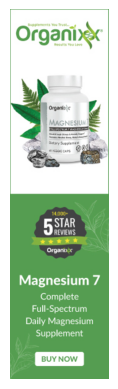

In [ ]:
import matplotlib.pyplot as plt
# Redimensionner sans distorsion
new_size = (224, int((height / width) * 224))
image_resized = image.resize(new_size)


# Afficher l'image dans le notebook
plt.imshow(image_resized)
plt.axis("off")  # Supprimer les axes
plt.show()



🔹 Redimensionner les images

In [ ]:
import numpy as np
from PIL import Image

# Liste pour stocker les images redimensionnées
image_arrays = []
target_size = (224, 224)  # Taille de redimensionnement

# Convertir les images
for sample in dataset["train"]:
    image = sample["image"]
    if not isinstance(image, Image.Image):
        image = Image.open(image)  # Charger l'image si ce n'est pas déjà un objet PIL

    # Vérifier si l'image a un canal de transparence
    if image.mode == "P" or image.mode == "RGBA":
        image = image.convert("RGBA")  # Assurer la conversion RGBA
        image_data = np.array(image)
        image = Image.fromarray(image_data[:, :, :3])  # Enlever le canal Alpha (transparence)
    else:
        image = image.convert("RGB")  # Convertir directement en RGB si pas de transparence

    # Redimensionner l'image
    image_resized = image.resize(target_size)
    image_array = np.array(image_resized)  # Convertir en array NumPy

    image_arrays.append(image_array)

# Convertir en tableau NumPy
X_images = np.array(image_arrays)

# Vérifier la forme du tableau
print("Shape of X_images:", X_images.shape)


Shape of X_images: (9003, 224, 224, 3)


2️⃣ Convertir les images en tableaux numériques


In [ ]:
def image_to_array(image):
    return np.array(image)

# Convertir toutes les images en arrays
image_arrays = [image_to_array(image) for image in processed_images]


NameError: name 'processed_images' is not defined

🔹 Nettoyage et Tokenisation du texte


In [ ]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords si ce n'est pas encore fait
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Fonction de nettoyage de texte
def clean_text(text):
    if not isinstance(text, str):  # Vérifier si le texte est valide
        return ""

    # 1. Convertir le texte en minuscules
    text = text.lower()

    # 2. Supprimer les URLs
    text = re.sub(r'http\S+', '', text)

    # 3. Supprimer les caractères spéciaux et chiffres (garder uniquement les lettres)
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Supprimer les stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

# Nettoyer les descriptions dans le dataset
cleaned_texts = [clean_text(sample["text"]) for sample in dataset["train"]]

# Créer un tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Ajout d'un token pour les mots inconnus

# Adapter le tokenizer sur les textes nettoyés
tokenizer.fit_on_texts(cleaned_texts)

# Transformer le texte en séquences d'indices
sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Ajouter du padding pour avoir des séquences de même longueur
max_length = 120  # Choisir la longueur maximale des séquences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Vérifier un exemple de séquence
print("Exemple de séquence tokenisée :", padded_sequences[0])

# Afficher quelques mots du dictionnaire
print("Quelques mots du vocabulaire :", list(tokenizer.word_index.items())[:10])
X_text = tokenizer.texts_to_sequences(cleaned_texts)  # Convertir les textes en séquences d'entiers
X_text = pad_sequences(X_text, maxlen=max_length)  # Compléter les séquences pour qu'elles aient la même longueur



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exemple de séquence tokenisée : [3120  283 6013  673   66 6014 1752 9225 4583 1753  394  419 6015 1752
  477 3665  121 1752 1753   20    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Quelques mots du vocabulaire : [('<OOV>', 1), ('learn', 2), ('get', 3), ('free', 4), ('shop', 5), ('new', 6), ('click', 7), ('best', 8), ('today', 9), ('one', 10)]


In [ ]:
texts = [sample["text"] for sample in dataset["train"]]  # Récupérer toutes les descriptions
print(len(texts))  # Vérifier si on a bien 9003 descriptions


9003


4️⃣ Fusionner les images et les descriptions


In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, Flatten, LSTM, Concatenate
from tensorflow.keras.models import Model

# Input pour l'image
image_input = Input(shape=(224, 224, 3))

# Feature extraction pour les images (par exemple, utiliser un CNN pré-entrainé comme ResNet50)
# image_features = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
image_features = Conv2D(32, (3, 3), activation='relu')(image_input)
image_features = Flatten()(image_features)

# Input pour le texte
text_input = Input(shape=(max_length,))

# Embedding du texte
text_embedding = Embedding(input_dim=10000, output_dim=128)(text_input)
text_features = LSTM(128)(text_embedding)

# Fusionner les deux flux (image + texte)
merged = Concatenate()([image_features, text_features])

# Ajout de couches entièrement connectées
output = Dense(1, activation='sigmoid')(merged)

# Créer le modèle
model = Model(inputs=[image_input, text_input], outputs=output)
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Feature extraction pour les images (par exemple, utiliser un CNN pré-entrainé comme ResNet50)
#image_features = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
#image_features = Flatten()(image_features)

y = np.array(X_images)  # Cibles : les images elles-mêmes


# Entraîner le modèle
model.fit([X_images, X_text], y, epochs=10, batch_size=32)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 120)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 120, 128)       │      1,280,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1577088)        │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 128)            │        131,584 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1577216)        │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │      1,577,217 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,989,697 (11.40 MB)

 Trainable params: 2,989,697 (11.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 224, 224, 3), output.shape=(None, 1)

5️⃣ Entraîner ton modèle


In [ ]:
print(dataset["train"].features)  # Affiche les noms des colonnes disponibles


{'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None), 'dimensions': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [ ]:
print(dataset["train"][0])  # Vérifie si "text" est bien présent


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x600 at 0x7BFE94840290>, 'text': 'Supplements You Trust\nOrganix\nResults You Love\nOrgani\nMAGNESIUM\nIak\nDietary Supplement\n001\n14,000+\n5 STAR\nREVIEWS\nOrganixor\nMagnesium 7\nComplete\nFull-Spectrum\nDaily Magnesium\nSupplement\nBUY NOW', 'dimensions': [160, 600]}


Nombre de descriptions : 38
Nombre d'images : 9003


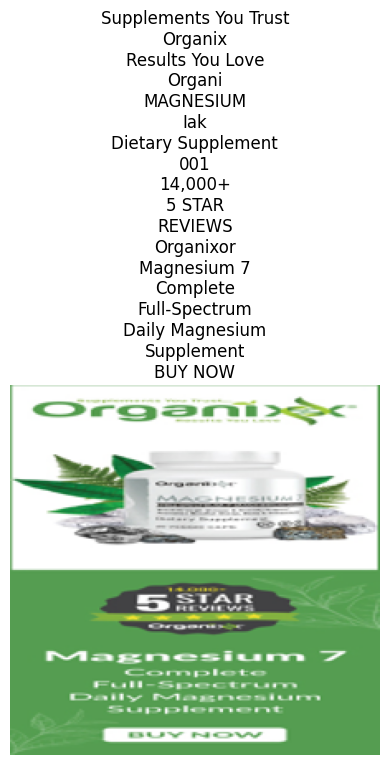

In [ ]:
import matplotlib.pyplot as plt

# Vérifier que texts et X_images sont bien définis
print("Nombre de descriptions :", len(text))
print("Nombre d'images :", len(X_images))

# Choisir un index d'exemple
index = 0

# Afficher l'image
plt.imshow(X_images[index])
plt.title(texts[index])  # Assure-toi que texts[index] existe bien
plt.axis("off")
plt.show()


In [ ]:
# Diviser les données en entrées (images et texte) et les cibles
X_text = padded_sequences
y = np.array(X_images)  # Cibles : les images elles-mêmes

# Compiler et entraîner le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([X_images, X_text], y, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 224, 224, 3), output.shape=(None, 1)

In [ ]:
# Diviser les données en entrées (images et texte) et les cibles
X_text = padded_sequences
#X_images = np.array(image_arrays)  # Les images prétraitées
y = np.array([sample["text"] for sample in dataset["train"]])  # Cibles : les labels des images

# Si vous avez plusieurs classes, vous pouvez convertir les labels en one-hot
from keras.utils import to_categorical
num_classes = 10  # Remplacez par le nombre réel de classes
y = to_categorical(y, num_classes=num_classes)

# Compiler et entraîner le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit([X_images, X_text], y, epochs=10, batch_size=32)


ValueError: invalid literal for int() with base 10: np.str_('Supplements You Trust\nOrganix\nResults You Love\nOrgani\nMAGNESIUM\nIak\nDietary Supplement\n001\n14,000+\n5 STAR\nREVIEWS\nOrganixor\nMagnesium 7\nComplete\nFull-Spectrum\nDaily Magnesium\n

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convertir dataset["train"] en un DataFrame Pandas
train_df = pd.DataFrame(dataset["train"])

# Diviser le dataset en train et test (80% train, 20% test)
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Nettoyer le texte pour l'ensemble d'entraînement et de test
train_texts = [clean_text(sample["text"]) for sample in train_data.to_dict(orient="records")]
test_texts = [clean_text(sample["text"]) for sample in test_data.to_dict(orient="records")]

# Créer un tokenizer et adapter sur l'ensemble d'entraînement
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Transformer le texte en séquences pour l'entraînement et le test
X_train_text = tokenizer.texts_to_sequences(train_texts)
X_test_text = tokenizer.texts_to_sequences(test_texts)

# Ajouter du padding pour avoir des séquences de même longueur
max_length = 120  # Choisir la longueur maximale des séquences
X_train_text = pad_sequences(X_train_text, maxlen=max_length, padding="post", truncating="post")
X_test_text = pad_sequences(X_test_text, maxlen=max_length, padding="post", truncating="post")

# Convertir les labels en one-hot (en supposant que vos labels sont dans 'y')
y_train = np.array([sample["text"] for sample in train_data.to_dict(orient="records")])  # Remplacer 'label' par le nom de la colonne de labels
y_test = np.array([sample["text"] for sample in test_data.to_dict(orient="records")])  # Remplacer 'label' par le nom de la colonne de labels

from keras.utils import to_categorical
num_classes = 10  # Remplacez par le nombre réel de classes
# Convertir en one-hot
num_classes = len(label_encoder.classes_)  # Nombre de classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Maintenant, vous pouvez entraîner votre modèle avec les données d'entraînement et de test
model.fit([X_train_images, X_train_text], y_train, epochs=10, batch_size=32)
